In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm
from sklearn import datasets

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [3]:
np.random.seed(249)
xx, y = datasets.make_circles(n_samples=300, factor=0.5, noise=0.05)
x_ = np.random.randn(50, 2)*0.1
xx = np.concatenate([xx, x_], axis=0)
y = np.concatenate([y, np.ones(len(x_), dtype=int)*0])

In [4]:
# np.random.seed(249) ## 148, 249

# xxc, yc = datasets.make_circles(n_samples=265, factor=.5,
#                                       noise=.07)
# idx = yc==0
# xxc = xxc[idx]
# yc = yc[idx]

# idx = (xxc[:,0]+xxc[:,1]<1)
# xxc = xxc[idx]
# yc = yc[idx]


# xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
# xxm = xxm/2 - 0.2

# xx = np.concatenate((xxm, xxc), axis=0)
# y = np.concatenate((ym, yc+2), axis=0)

In [5]:
np.unique(y, return_counts=True)

(array([0, 1]), array([200, 150]))

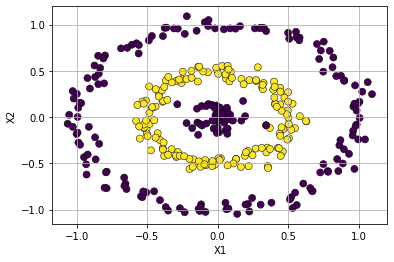

In [6]:
## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
# x1 = (x1-x1.min())/(x1.max()-x1.min())
# x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

xx = torch.Tensor(xx)
yy = torch.Tensor(y.reshape(-1, 1))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

# (x1min, x1max) = -0.1, 1.1
# plt.xlim((x1min, x1max))
# plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [7]:
class ST_Sigmoid(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x):
        zz = 1/(1+torch.exp(-x))
        ctx.save_for_backward(zz)
        
        output = (x>0).type(x.dtype)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        zz, = ctx.saved_tensors
        grad_x = None
        
        if ctx.needs_input_grad[0]:
            grad_x = zz*(1-zz)*grad_output

        return grad_x

In [51]:
class PWG_Sigmoid(torch.autograd.Function):### piecewise gradient leaky signum
    
    @staticmethod
    def forward(ctx, x):
#         zz = 1/(1+torch.exp(-4*x))
        zz = (x>0).type(x.dtype)
        
        x=x+0.5
        o1x = 0.1*x
#         x = torch.minimum(torch.maximum(x, o1x), o1x+0.9) ## this is leaky signum
        mask0 = x > o1x
        mask1 = x < (o1x + 0.9)
        mask = torch.bitwise_and(mask0, mask1).type(x.dtype)
        gs = mask + 0.1*(1-mask) ## gradient scaler
        ctx.save_for_backward(gs)
        
        return zz

    @staticmethod
    def backward(ctx, grad_output):
        gs, = ctx.saved_tensors
        grad_x = None
        
        if ctx.needs_input_grad[0]:
            grad_x = gs*grad_output

        return grad_x

In [52]:
class DistanceBinaryClassifier(nn.Module):
    def __init__(self, input_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
#         self.actf = nn.Sigmoid()
#         self.actf = ST_Sigmoid.apply
        self.actf = PWG_Sigmoid.apply

        
    def forward(self, x, hard=False):
        x = torch.norm(x-self.centers, dim=1, keepdim=True) + self.bias
        if hard:
            x = torch.sigmoid(-x*1e5)
        else:
            x = self.actf(-x*self.inv_temp)
        return x

## Model Train

In [53]:
class DistanceBinaryClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)

#         self.actf = nn.Sigmoid()
#         self.actf = ST_Sigmoid.apply
        self.actf = PWG_Sigmoid.apply

        self.pos_val = nn.Parameter(torch.ones(1, output_dim)*0.5)
        self.neg_val = nn.Parameter(torch.ones(1, output_dim)*0.5)
        
    def forward(self, x, hard=False):
        self.pos_val.data.abs_()
        self.pos_val.data = self.pos_val.data/self.pos_val.data.sum()
        self.neg_val.data.abs_()
        self.neg_val.data = self.neg_val.data/self.neg_val.data.sum()
        
        x = torch.norm(x-self.centers, dim=1, keepdim=True) + self.bias
        if hard:
            x = torch.sigmoid(-x*1e5)
        else:
            x = self.actf(-x*self.inv_temp)
        x = x*self.pos_val + (1-x)*self.neg_val
        return x

In [54]:
ycls = yy.reshape(-1).type(torch.long)

ycls_ = torch.zeros(len(ycls), ycls.max()+1)
ycls_[torch.arange(0, len(ycls), dtype=torch.long), ycls] = 1.

In [55]:
# ycls_, ycls

In [56]:
actf = irf.Swish
flows = [
    ActNorm(2),
    irf.ResidualFlow(2, [5], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [5], activation=actf),
    ActNorm(2),
        ]

model = SequentialFlow(flows)

In [57]:
classifier = DistanceBinaryClassifier(2, ycls.max().item()+1, inv_temp=0.1)

In [58]:
criterion = nn.MSELoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=0.0031)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  68


In [59]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca()#projection='3d')

model.train()
losses = []
NUM = 512

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

for epoch in tqdm(range(1000*4+1)):
    optimizer.zero_grad()
    
    z = model(xx)
    yout = classifier(z)
    
    loss = criterion(yout, ycls_)
    loss.backward()
    optimizer.step()
        
    if epoch%100 == 0:
        acc = (yout.data.argmax(dim=1) == ycls)
        acc = float(acc.type(torch.float32).mean())
        losses.append(float(loss))
        print(f"Epoch: {epoch} Loss: {losses[-1]} Accuracy: {acc}")

        ax.clear()
        with torch.no_grad():
            z = model(xx)
            yout = classifier(z)
            
        yout_img = classifier(model(xyg))
        out = yout_img.data.argmax(dim=1).numpy()
#         out = yout_img.data[torch.arange(0, len(out), dtype=torch.long), out.reshape(-1)].numpy()
        cf = ax.contourf(xg, yg, out.reshape(xg.shape),# v,
                         alpha=0.5, antialiased=True)
        ax.grid()

        ax.scatter(x1, x2, c=ycls.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.data.argmax(dim=1).numpy().reshape(-1), marker='.')
            
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        
        fig.canvas.draw()
        plt.pause(0.01)


  0%|          | 0/4001 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.25 Accuracy: 0.5714285969734192


  2%|▏         | 91/4001 [00:01<00:28, 138.84it/s]

Epoch: 100 Loss: 0.2620523273944855 Accuracy: 0.43714284896850586


  5%|▍         | 184/4001 [00:01<00:26, 144.41it/s]

Epoch: 200 Loss: 0.24417847394943237 Accuracy: 0.5714285969734192


  7%|▋         | 281/4001 [00:02<00:24, 153.77it/s]

Epoch: 300 Loss: 0.1317083239555359 Accuracy: 0.8571428656578064


 10%|▉         | 396/4001 [00:03<00:21, 165.94it/s]

Epoch: 400 Loss: 0.11043845117092133 Accuracy: 0.8514285683631897


 12%|█▏        | 491/4001 [00:04<00:23, 151.67it/s]

Epoch: 500 Loss: 0.11033249646425247 Accuracy: 0.8514285683631897


 15%|█▍        | 585/4001 [00:05<00:22, 150.63it/s]

Epoch: 600 Loss: 0.11033116281032562 Accuracy: 0.8514285683631897


 17%|█▋        | 682/4001 [00:05<00:21, 154.40it/s]

Epoch: 700 Loss: 0.11501124501228333 Accuracy: 0.8428571224212646


 20%|█▉        | 788/4001 [00:06<00:23, 137.58it/s]

Epoch: 800 Loss: 0.11189346015453339 Accuracy: 0.8485714197158813


 22%|██▏       | 891/4001 [00:07<00:22, 140.08it/s]

Epoch: 900 Loss: 0.10876113921403885 Accuracy: 0.854285717010498


 25%|██▍       | 992/4001 [00:08<00:20, 147.12it/s]

Epoch: 1000 Loss: 0.1181664913892746 Accuracy: 0.8371428847312927


 27%|██▋       | 1087/4001 [00:09<00:19, 152.64it/s]

Epoch: 1100 Loss: 0.11345016211271286 Accuracy: 0.845714271068573


 30%|██▉       | 1183/4001 [00:10<00:18, 155.95it/s]

Epoch: 1200 Loss: 0.1103455126285553 Accuracy: 0.8514285683631897


 32%|███▏      | 1296/4001 [00:11<00:16, 159.51it/s]

Epoch: 1300 Loss: 0.11038132011890411 Accuracy: 0.8514285683631897


 35%|███▍      | 1390/4001 [00:11<00:17, 145.87it/s]

Epoch: 1400 Loss: 0.11969738453626633 Accuracy: 0.8342857360839844


 37%|███▋      | 1485/4001 [00:12<00:17, 144.72it/s]

Epoch: 1500 Loss: 0.11348322033882141 Accuracy: 0.845714271068573


 40%|███▉      | 1600/4001 [00:13<00:15, 157.94it/s]

Epoch: 1600 Loss: 0.11189965158700943 Accuracy: 0.8485714197158813


 42%|████▏     | 1698/4001 [00:14<00:14, 156.01it/s]

Epoch: 1700 Loss: 0.13273151218891144 Accuracy: 0.8285714387893677


 45%|████▍     | 1796/4001 [00:15<00:14, 153.30it/s]

Epoch: 1800 Loss: 0.11032568663358688 Accuracy: 0.8514285683631897


 47%|████▋     | 1894/4001 [00:16<00:13, 153.96it/s]

Epoch: 1900 Loss: 0.10874642431735992 Accuracy: 0.854285717010498


 50%|████▉     | 1989/4001 [00:16<00:12, 154.87it/s]

Epoch: 2000 Loss: 0.10885913670063019 Accuracy: 0.8571428656578064


 52%|█████▏    | 2081/4001 [00:17<00:14, 136.98it/s]

Epoch: 2100 Loss: 0.11032533645629883 Accuracy: 0.8514285683631897


 55%|█████▍    | 2199/4001 [00:18<00:11, 160.65it/s]

Epoch: 2200 Loss: 0.12199229747056961 Accuracy: 0.845714271068573


 57%|█████▋    | 2297/4001 [00:19<00:10, 156.02it/s]

Epoch: 2300 Loss: 0.11037945002317429 Accuracy: 0.8514285683631897


 60%|█████▉    | 2395/4001 [00:20<00:10, 152.30it/s]

Epoch: 2400 Loss: 0.23932290077209473 Accuracy: 0.5942857265472412


 62%|██████▏   | 2492/4001 [00:21<00:09, 158.83it/s]

Epoch: 2500 Loss: 0.2448979914188385 Accuracy: 0.5714285969734192


 65%|██████▍   | 2591/4001 [00:21<00:08, 157.24it/s]

Epoch: 2600 Loss: 0.2448979616165161 Accuracy: 0.5714285969734192


 67%|██████▋   | 2686/4001 [00:22<00:09, 144.53it/s]

Epoch: 2700 Loss: 0.24489794671535492 Accuracy: 0.5714285969734192


 70%|██████▉   | 2792/4001 [00:23<00:09, 129.14it/s]

Epoch: 2800 Loss: 0.24489794671535492 Accuracy: 0.5714285969734192


 72%|███████▏  | 2899/4001 [00:24<00:07, 146.62it/s]

Epoch: 2900 Loss: 0.24489794671535492 Accuracy: 0.5714285969734192


 75%|███████▍  | 2993/4001 [00:25<00:06, 147.81it/s]

Epoch: 3000 Loss: 0.24489794671535492 Accuracy: 0.5714285969734192


 77%|███████▋  | 3089/4001 [00:26<00:06, 144.30it/s]

Epoch: 3100 Loss: 0.24489794671535492 Accuracy: 0.5714285969734192


 80%|███████▉  | 3186/4001 [00:27<00:05, 149.32it/s]

Epoch: 3200 Loss: 0.24489794671535492 Accuracy: 0.5714285969734192


 82%|████████▏ | 3283/4001 [00:28<00:04, 154.29it/s]

Epoch: 3300 Loss: 0.2448979914188385 Accuracy: 0.5714285969734192


 85%|████████▍ | 3386/4001 [00:28<00:04, 143.18it/s]

Epoch: 3400 Loss: 0.2448979914188385 Accuracy: 0.5714285969734192


 85%|████████▍ | 3400/4001 [00:29<00:05, 116.25it/s]


TclError: invalid command name "pyimage66"

In [ ]:
yout

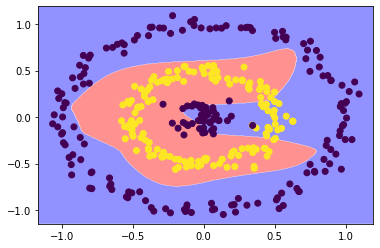

In [30]:
model.eval()
%matplotlib inline

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

with torch.no_grad():
    z = model(xyg, False)
    y = torch.argmax(classifier(z, hard=True), dim=1)
    
cf = plt.contourf(xg, yg, y.reshape(xg.shape),# v,
                     alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, marker='o', c=yy.reshape(-1))

In [123]:
torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True)

ModuleAttributeError: 'DistanceBinaryClassifier' object has no attribute 'cls_confidence'

In [ ]:
plt.scatter(z[:,0], z[:,1], marker='.', c=y.reshape(-1))   

In [ ]:
plt.scatter(z[:,0], z[:,1], marker='.', c=cls, cmap='tab10')   
centers = torch.zeros(classifier.num_sets, z.shape[1])
for i, c in enumerate(classifier.centers.data.t()):
    centers[:, i] = c
plt.scatter(*centers.t(), marker='*', s=300, edgecolors='k', c=list(range(classifier.num_sets)), cmap='tab10')

In [ ]:
torch.unique(cls)

In [ ]:
torch.unique(cls, return_counts=True)

In [ ]:
list(range(classifier.num_sets))

In [ ]:
x__ = x_*(centers.max())
classifier(x__)
cls_ = torch.argmax(classifier.cls_confidence, dim=1)
# for i, u in enumerate(torch.unique(cls_)):
#     cls_[cls_==u] = i
plt.scatter(x__[:,0], x__[:,1], marker='.', c=cls_, cmap='tab10') 
plt.scatter(*centers.t(), marker='*', s=100, edgecolors='k', c=list(range(classifier.num_sets)), cmap='tab10')

In [ ]:
model.eval()

ng = 20
_a,_b,_c,_d = x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1
xx, yy = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
x = torch.Tensor(xy)
z = model(x)
print(z.shape)

x = x.detach().numpy()
z = z.detach().numpy()
plt.figure(figsize=(20,20))
plt.scatter(z[:,0], z[:,1], c='r', s=5)
z = z.reshape(ng, ng, -1)
for i in range(ng):
    plt.plot(z[:, i, 0], z[:, i, 1], marker='.')
for i in range(ng):
    plt.plot(z[i, :, 0], z[i, :, 1], marker='.')
    
plt.title('x -> z')